In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose


import random
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.model_selection import cross_val_score


import warnings
import os
import sys


root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(root_dir)

from utils.utils import *
from utils.constant import *

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")
# Set a seed for reproducibility
np.random.seed(42)


In [2]:
file_path = get_absolute_path(
    'join_wo_forecast_error.csv',
    'data',
    PROJECT_BASE_DIR
)

data = pd.read_csv(file_path)

In [3]:
# Combine 'PRODUCT_CATEGORY_LEVEL1' and 'PRODUCT_CATEGORY_LEVEL3' into a new column
data['SEGMENT'] = data['CATEGORY_LEVEL1'] + ' - ' + data['CATEGORY_LEVEL3']


In [4]:
len(data)

12878697

In [5]:
### Basic Information about the Datasets

# Display basic information about the dataset
print(data.info())

# Display summary statistics for numerical columns
print(data.describe())

# Check for missing values
print(data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12878697 entries, 0 to 12878696
Data columns (total 14 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ORDER_PLACED_DTTM      object 
 1   PRODUCT_PART_NUMBER    int64  
 2   TOTAL_UNITS            float64
 3   TOTAL_CURRENT_ON_HAND  int64  
 4   CATEGORY_LEVEL1        object 
 5   CATEGORY_LEVEL2        object 
 6   CATEGORY_LEVEL3        object 
 7   MERCH_CLASSIFICATION1  object 
 8   MERCH_CLASSIFICATION2  object 
 9   MERCH_CLASSIFICATION3  object 
 10  LIST_PRICE             float64
 11  RATING_AVG             float64
 12  RATING_CNT             float64
 13  SEGMENT                object 
dtypes: float64(4), int64(2), object(8)
memory usage: 1.3+ GB
None
       PRODUCT_PART_NUMBER   TOTAL_UNITS  TOTAL_CURRENT_ON_HAND    LIST_PRICE  \
count         1.287870e+07  1.287870e+07           1.287870e+07  1.132517e+07   
mean          2.405747e+05  4.082814e+01           1.042794e+03  3.387225e+01   

In [6]:
len(data)

12878697

In [7]:
# Update the original DataFrame after dropping NaNs
data = data.dropna()


In [8]:
len(data)

10635060

In [9]:
print(len(data.SEGMENT.unique()))
data.SEGMENT.unique()

357


array(['Dog - Biscuits & Crunchy Treats', 'Dog - Jerky Treats',
       'Dog - Soft & Chewy Treats', 'Dog - Wet Food',
       'Small Pet - Bedding', 'Dog - Dry Food', 'Cat - Dry Food',
       'Cat - Wet Food', 'Cat - Crunchy Treats', 'Dog - Hard Chews',
       'Dog - Dental Treats', 'Dog - Beds', 'Dog - Bowls & Diners',
       'Cat - Furniture', 'Dog - Crate Mats',
       'Dog - Vitamins & Supplements', 'Cat - Vitamins & Supplements',
       'Fish - Salt & Minerals', 'Fish - Water Test Kits',
       'Dog - Creams & Rinses', 'Dog - Natural Chews', 'Bird - Food',
       'Small Pet - Food', 'Dog - Toys', 'Dog - Leashes',
       'Dog - Harnesses', 'Dog - Tie Outs', 'Dog - Sprays, Foams & Wipes',
       'Dog - Brushes & Combs', 'Cat - Sprays, Foams & Wipes',
       'Small Pet - Feeders', 'Small Pet - Toys', 'Small Pet - Bowls',
       'Small Pet - Tools & Accessories',
       'Small Pet - Pans & Accessories', 'Small Pet - Hideouts',
       'Small Pet - Cages', 'Fish - Filter Media',
       '

In [11]:
### Basic Information about the Datasets

# Display basic information about the dataset
print(data.info())

# Display summary statistics for numerical columns
print(data.describe())

# Check for missing values
print(data.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
Index: 10635060 entries, 0 to 12878696
Data columns (total 14 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ORDER_PLACED_DTTM      object 
 1   PRODUCT_PART_NUMBER    int64  
 2   TOTAL_UNITS            float64
 3   TOTAL_CURRENT_ON_HAND  int64  
 4   CATEGORY_LEVEL1        object 
 5   CATEGORY_LEVEL2        object 
 6   CATEGORY_LEVEL3        object 
 7   MERCH_CLASSIFICATION1  object 
 8   MERCH_CLASSIFICATION2  object 
 9   MERCH_CLASSIFICATION3  object 
 10  LIST_PRICE             float64
 11  RATING_AVG             float64
 12  RATING_CNT             float64
 13  SEGMENT                object 
dtypes: float64(4), int64(2), object(8)
memory usage: 1.2+ GB
None
       PRODUCT_PART_NUMBER   TOTAL_UNITS  TOTAL_CURRENT_ON_HAND    LIST_PRICE  \
count         1.063506e+07  1.063506e+07           1.063506e+07  1.063506e+07   
mean          2.193796e+05  3.264352e+01           9.856310e+02  3.394665e+01   
std 

# EM Algorithm / Gaussian Mixture Model for Anomaly Detection

3 Major Things to Pay Attention to:

1. Our data contains missing values (NaN), and the GaussianMixture algorithm does not handle missing values natively. To address this issue, we need to handle missing values (I just dropped the `NET_SALES` or `UNITS` records that contains missing values) in our data before fitting the model. 
2. Need to tune hyperparameter `n_components`.
3. Need to decide the `threshold`.

### Given `n_components` and `threshold`

In this section, we assume `n_components = 5` (in this selected data, we have 8 segments), and `threshold = -50`. 


In [12]:
# Select the columns for anomaly detection
columns_for_anomaly_detection = ['TOTAL_UNITS',
    'LIST_PRICE', 
    'RATING_AVG', 
    'RATING_CNT',
    'TOTAL_CURRENT_ON_HAND'
                                        ] # # metric_set 
data_for_anomaly_detection = data[columns_for_anomaly_detection]

# Check for missing values and handle them (replace NaN with a suitable strategy, e.g., mean)



In [13]:
# Standardize the data
scaler = StandardScaler()
data_for_anomaly_detection_standardized = scaler.fit_transform(data_for_anomaly_detection)



In [14]:
# Choose the number of components (clusters) for the GMM
n_components = 5  # adjust this based on the characteristics of your data

# Fit a Gaussian Mixture Model to the data
gmm = GaussianMixture(n_components=n_components, n_init=5, random_state=42)
gmm.fit(data_for_anomaly_detection_standardized)


GaussianMixture(n_components=5, n_init=5, random_state=42)

In [18]:
# Predict the labels (clusters) for each data point
labels = gmm.predict(data_for_anomaly_detection_standardized)

# Add the cluster labels to the original DataFrame
data['cluster_label'] = labels

In [16]:
columns_for_anomaly_detection

['TOTAL_UNITS',
 'LIST_PRICE',
 'RATING_AVG',
 'RATING_CNT',
 'TOTAL_CURRENT_ON_HAND']

#### GMM Predict Anomalies Using Percentage Threshold

We will use the results from the Gaussian Mixture Model (GMM) to predict anomalies based on a percentage threshold. This percentage threshold is usually obtained through historical data or business knowledge. 

- Firstly, the score for each sample is obtained using the `score_samples` method.
- Secondly, the score is saved as a column in the pandas dataframe.
- After that, we get the score value for the percentage threshold set up for the anomaly detection, say, 5\%.
- Finally, a column is created based on the threshold. The data point is predicted to be an outlier if the score is les than the threshold.

In [17]:
# Get the score for each sample
score = gmm.score_samples(data_for_anomaly_detection_standardized)

# Save the score as a column
data['score'] = score

# Get the score threshold for anomaly 1%
pct_threshold = np.percentile(score, 1)

# Print the score threshold
print(f'The threshold of the score is {pct_threshold:.2f}')

# Label the anomalies
data['anomaly_gmm_pct'] = data['score'].apply(lambda x: 1 if x < pct_threshold else 0)



The threshold of the score is -13.94


### GMM Predict Anomalies Using Value Threshold

We can use the results from Gaussian Mixture Model (GMM) to predict anomalies based on a value threshold. This value threshold is obtained by observing the distribution of scores. 

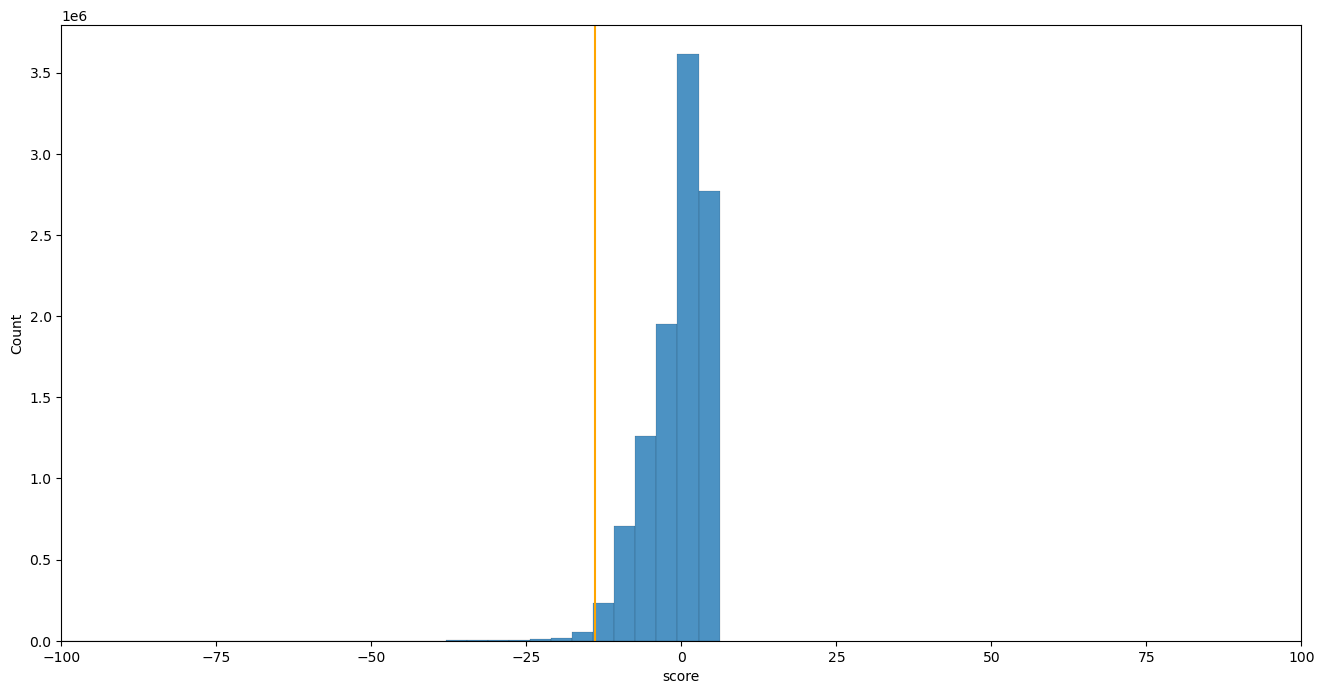

In [22]:
plt.figure(figsize = (16, 8))

sns.histplot(data['score'], bins = 1000, alpha=0.8)

plt.axvline(x=pct_threshold, color = 'orange')

# Limit x-axis range
plt.xlim(left=-100, right=100)

plt.show()

In [23]:
# # Get the score threshold for anomaly
# value_threshold = -7.88
# data['anomaly_gmm_value'] = data['score'].apply(lambda x: 1 if x < value_threshold else 0)


In [28]:
pct_threshold

-13.940905494697725

### GMM Anomaly Detection Optimization

- Hyperparameter Tuning
- Optimize the threshold

In [24]:
# Calculate the likelihood of each data point under the model
likelihoods = gmm.score_samples(data_for_anomaly_detection_standardized)

# Set a threshold for anomaly detection (you may need to adjust this)
threshold = pct_threshold  # Example threshold, adjust based on the distribution of likelihoods


In [29]:
len(data)

10635060

In [25]:
# Identify anomalies based on the threshold
anomalies = data[likelihoods < threshold]

# Print or further analyze the anomalies
print(f"Anomalies:{len(anomalies)}")
print(anomalies)

Anomalies:106351
         ORDER_PLACED_DTTM  PRODUCT_PART_NUMBER  TOTAL_UNITS  \
6079            2023-02-01               100118       1282.0   
30953           2023-04-29               100496        827.0   
30960           2023-05-06               100496        730.0   
30962           2023-05-08               100496        708.0   
30963           2023-05-09               100496        762.0   
...                    ...                  ...          ...   
12876109        2023-12-03                99967       1642.0   
12876110        2023-12-04                99967       1766.0   
12876111        2023-12-05                99967       1519.0   
12877669        2023-02-11                99977       1365.0   
12877670        2023-02-12                99977       1235.0   

          TOTAL_CURRENT_ON_HAND CATEGORY_LEVEL1 CATEGORY_LEVEL2  \
6079                       1112             Cat            Food   
30953                     33903             Dog            Food   
30960        

In [26]:
columns_for_anomaly_detection

['TOTAL_UNITS',
 'LIST_PRICE',
 'RATING_AVG',
 'RATING_CNT',
 'TOTAL_CURRENT_ON_HAND']

In [32]:
threshold

-13.940905494697725

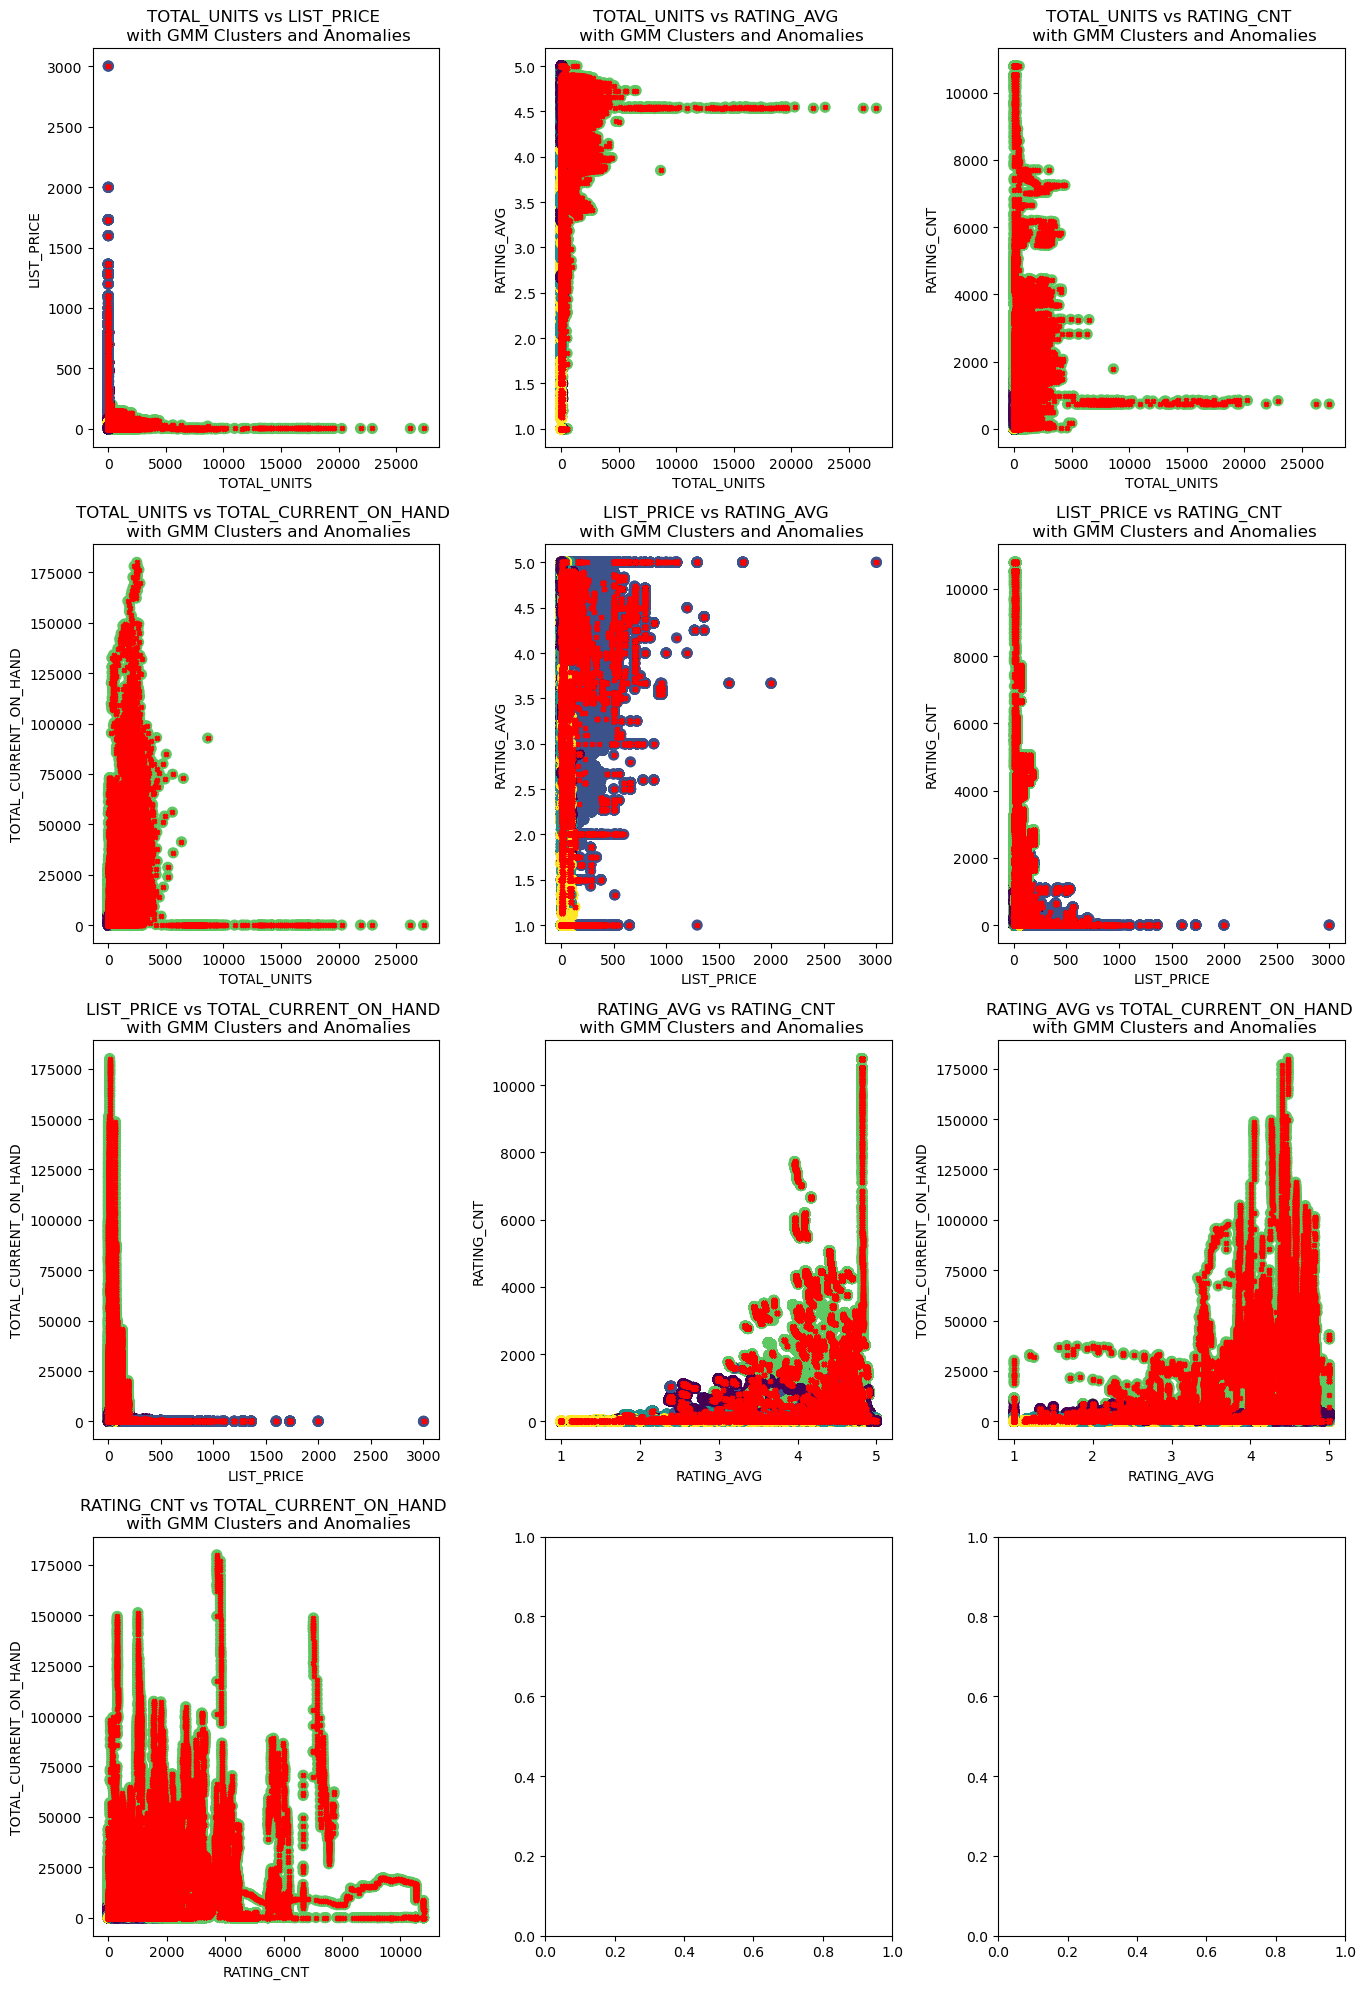

In [35]:
from itertools import combinations

# Assuming you have already fit the Gaussian Mixture Model (GMM) and computed likelihoods
# (labels from GMM and likelihoods can be obtained using model.predict and model.score_samples)

# Specify the columns for anomaly detection
columns_for_anomaly_detection = [
    'TOTAL_UNITS',
    'LIST_PRICE', 
    'RATING_AVG', 
    'RATING_CNT',
    'TOTAL_CURRENT_ON_HAND'
]

# Generate all combinations of columns
column_combinations = list(combinations(columns_for_anomaly_detection, 2))


# Create a grid of scatter plots
num_plots = len(column_combinations)
num_cols = 3
num_rows = -(-num_plots // num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Flatten the axes for easy indexing
axes = axes.flatten()

# Iterate over column combinations
for i, (col1, col2) in enumerate(column_combinations):
    scatter = axes[i].scatter(data[col1], data[col2], c=labels, cmap='viridis', marker='o', s=50)
    anomaly_mask = likelihoods < threshold
    anomalies = data[anomaly_mask]
    axes[i].scatter(anomalies[col1], anomalies[col2], c='red', marker='X', s=10, label='Anomalies')
    axes[i].set_xlabel(col1)
    axes[i].set_ylabel(col2)
    axes[i].set_title(f'{col1} vs {col2} \n with GMM Clusters and Anomalies')

# # Add a colorbar
# cbar = fig.colorbar(scatter, ax=axes)
# cbar.set_label('Cluster Label')

# Move the legend to the right of the plots
fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rect parameter to control the space for the legend
fig.subplots_adjust(right=0.9)  # Adjust the right parameter to control the space for the legend

# # Add a common legend outside the subplots
# fig.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Legend')
plt.show()

In [36]:
# Specify the columns for anomaly detection
columns_for_anomaly_detection 


['TOTAL_UNITS',
 'LIST_PRICE',
 'RATING_AVG',
 'RATING_CNT',
 'TOTAL_CURRENT_ON_HAND']

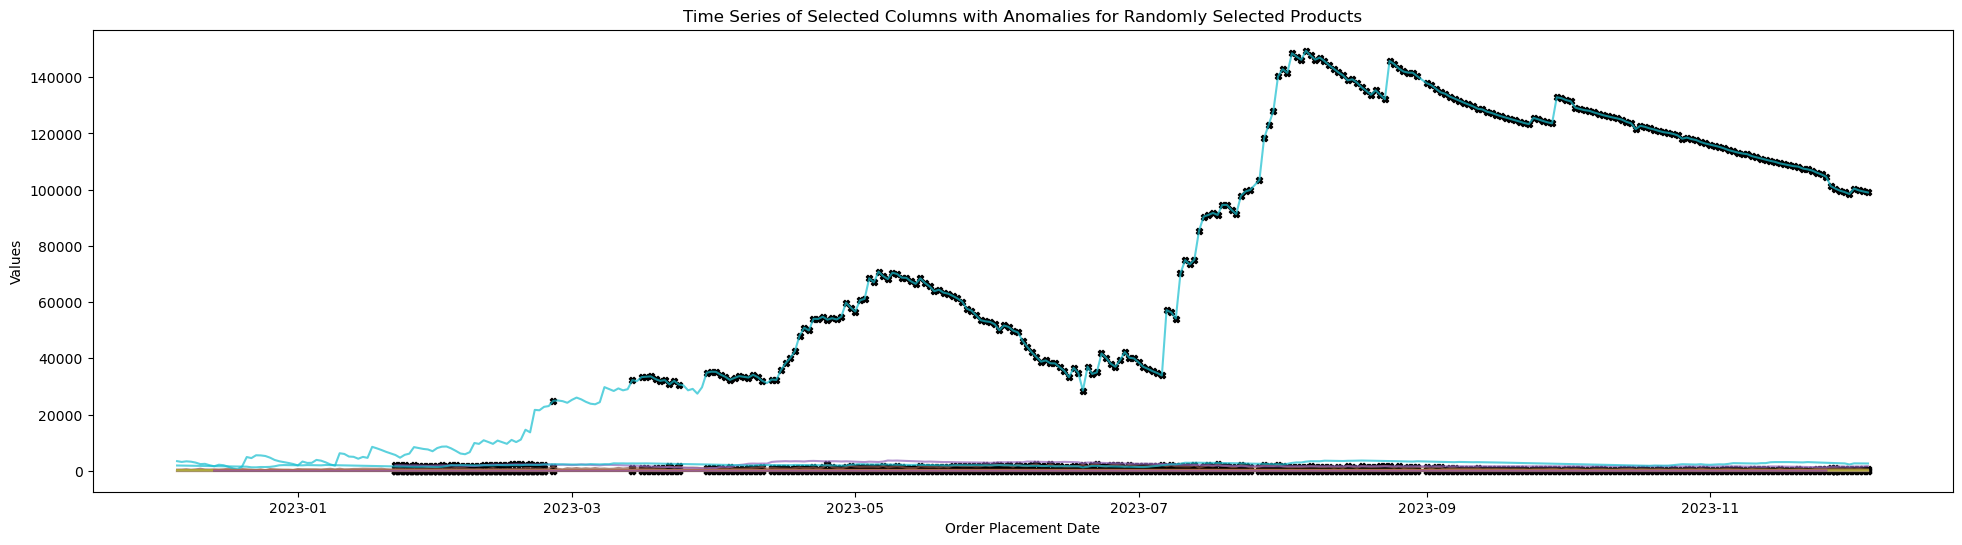

In [37]:
import random

# Assuming that 'ORDER_PLACED_DTTM' is a datetime index, if not, convert it to datetime
data['ORDER_PLACED_DTTM'] = pd.to_datetime(data['ORDER_PLACED_DTTM'])

# Identify anomalies based on the threshold (assuming 'likelihoods' and 'threshold' are defined)
anomaly_mask = likelihoods < threshold
anomalies = data[anomaly_mask]

# Get PRODUCT_PART_NUMBER values with anomalies
product_numbers_with_anomalies = anomalies['PRODUCT_PART_NUMBER'].unique()

# Get PRODUCT_PART_NUMBER values without anomalies
product_numbers_without_anomalies = data['PRODUCT_PART_NUMBER'].unique()
product_numbers_without_anomalies = list(set(product_numbers_without_anomalies) - set(product_numbers_with_anomalies))

# Randomly select a subset of PRODUCT_PART_NUMBER values that includes both cases
random_product_numbers_with_anomalies = random.sample(product_numbers_with_anomalies.tolist(), k=3)
random_product_numbers_without_anomalies = random.sample(product_numbers_without_anomalies, k=2)

random_product_numbers = random_product_numbers_with_anomalies + random_product_numbers_without_anomalies

# Plot time series of selected columns for each randomly selected PRODUCT_PART_NUMBER
plt.figure(figsize=(24, 6))

for product_number in random_product_numbers:
    product_data = data[data['PRODUCT_PART_NUMBER'] == product_number]
    product_anomalies = anomalies[anomalies['PRODUCT_PART_NUMBER'] == product_number]

    for column in columns_for_anomaly_detection:
        plt.plot(product_data['ORDER_PLACED_DTTM'], product_data[column], label=f'{column} - Product {product_number}', alpha=0.7)

        # Highlight anomalies for each product
        plt.scatter(product_anomalies['ORDER_PLACED_DTTM'], product_anomalies[column],
                    c='black', marker='X', s=20, label=f'Anomalies - {column} - Product {product_number}')

# Customize the plot
plt.xlabel('Order Placement Date')
plt.ylabel('Values')
plt.title('Time Series of Selected Columns with Anomalies for Randomly Selected Products')
# plt.legend()

# Show the plot
plt.show()


In [38]:
columns_for_anomaly_detection

['TOTAL_UNITS',
 'LIST_PRICE',
 'RATING_AVG',
 'RATING_CNT',
 'TOTAL_CURRENT_ON_HAND']

In [39]:
random_product_numbers_with_anomalies

[361428, 105777, 48102]

[914134, 49747, 333135, 121302, 551846]


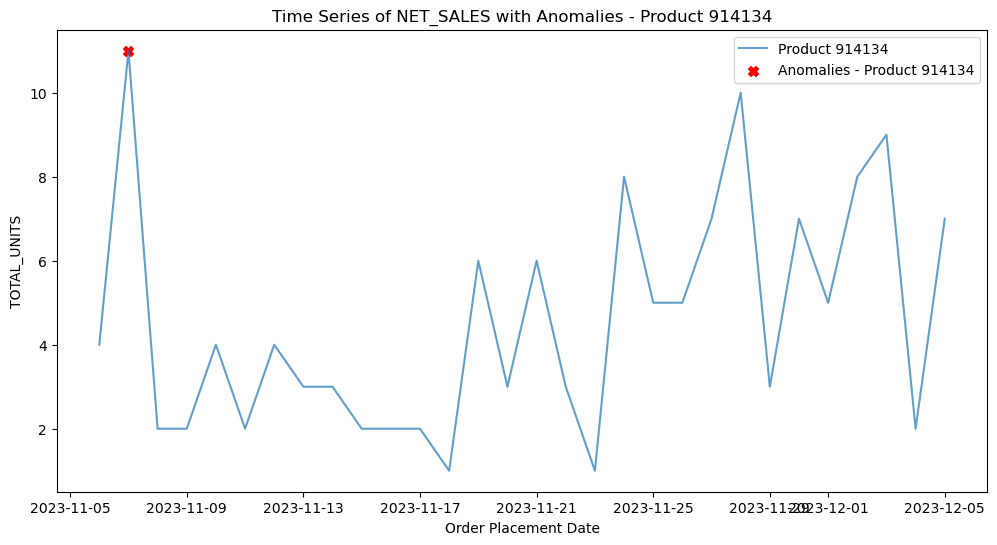

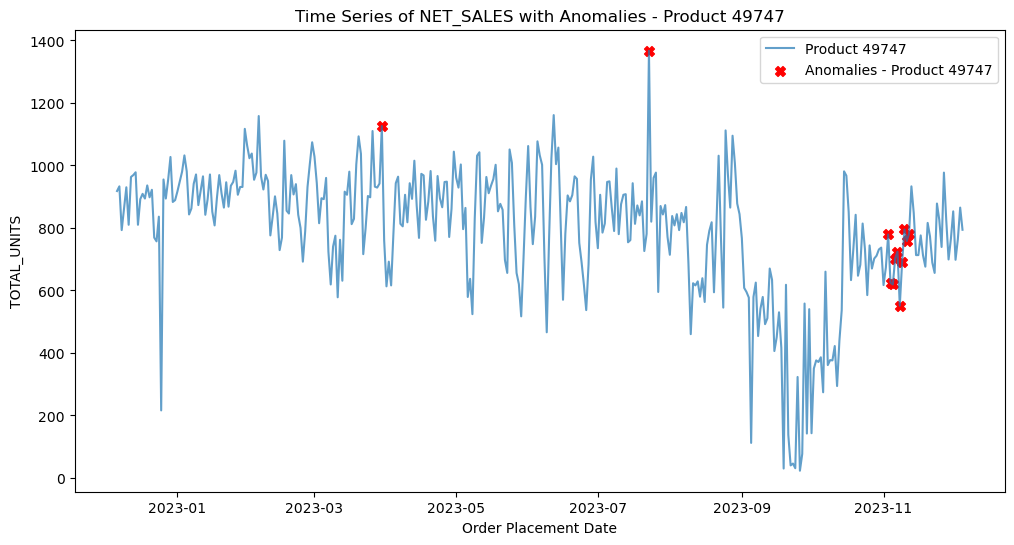

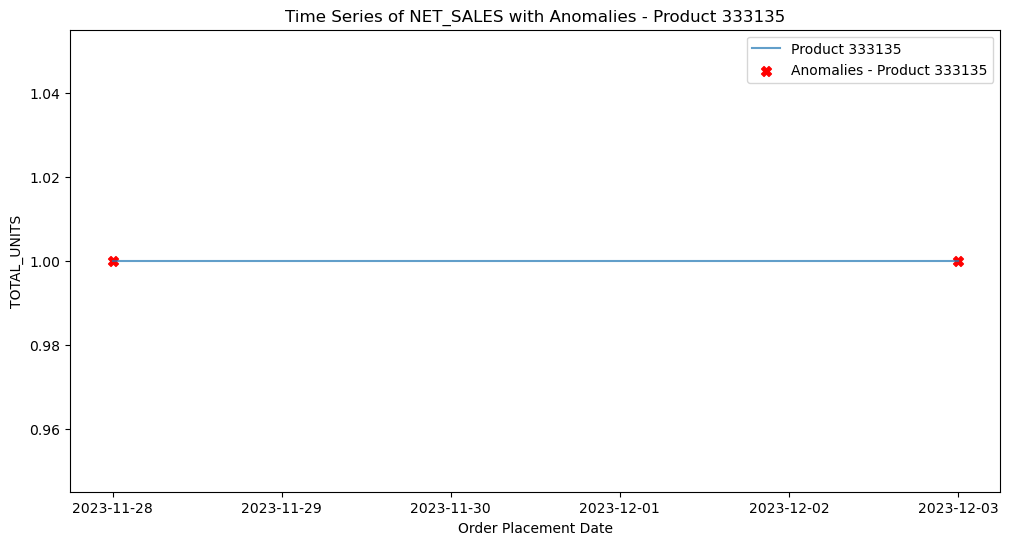

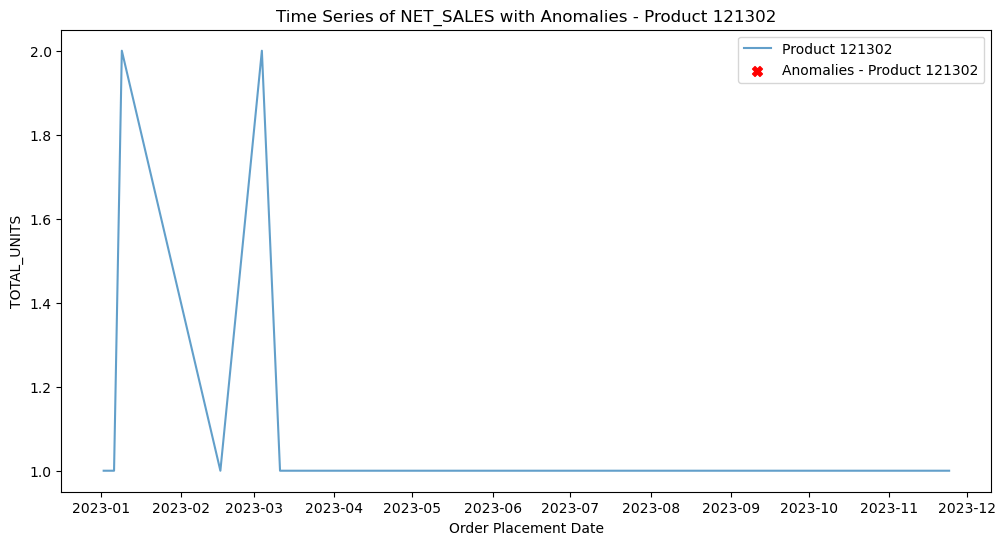

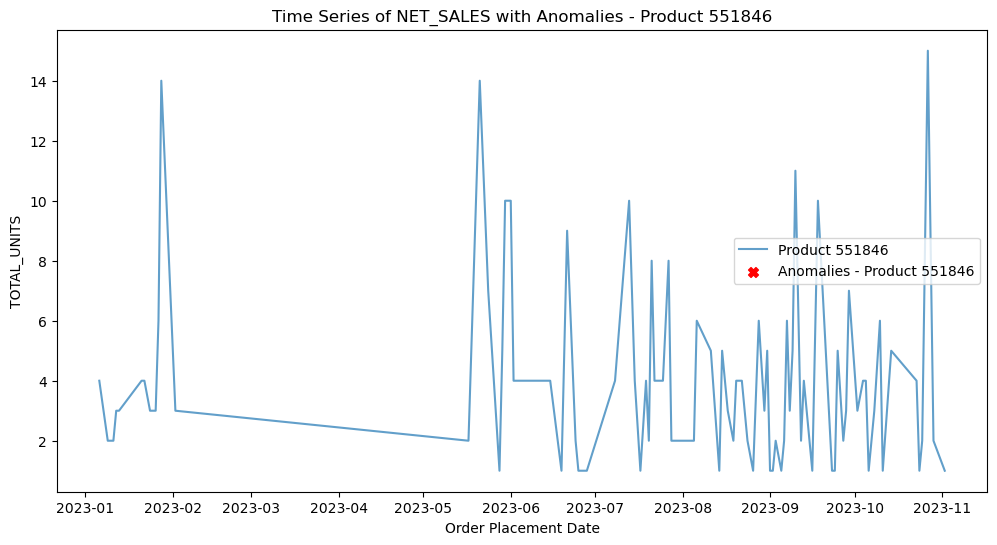

In [40]:
# Convert 'ORDER_PLACED_DTTM' to datetime if it's not already in datetime format
data['ORDER_PLACED_DTTM'] = pd.to_datetime(data['ORDER_PLACED_DTTM'])

# Identify anomalies based on the threshold
anomaly_mask = likelihoods < threshold
anomalies = data[anomaly_mask]

# Get PRODUCT_PART_NUMBER values with anomalies
product_numbers_with_anomalies = anomalies['PRODUCT_PART_NUMBER'].unique()

# Get PRODUCT_PART_NUMBER values without anomalies
product_numbers_without_anomalies = data['PRODUCT_PART_NUMBER'].unique()
product_numbers_without_anomalies = list(set(product_numbers_without_anomalies) - set(product_numbers_with_anomalies))


# 151436

# Randomly select a subset of PRODUCT_PART_NUMBER values that includes both cases
random_product_numbers_with_anomalies = random.sample(product_numbers_with_anomalies.tolist(), k=3)
random_product_numbers_without_anomalies = random.sample(product_numbers_without_anomalies, k=2)

random_product_numbers = random_product_numbers_with_anomalies + random_product_numbers_without_anomalies

print(random_product_numbers)

# Plot time series of NET_SALES for each randomly selected PRODUCT_PART_NUMBER
for product_number in random_product_numbers:
    plt.figure(figsize=(12, 6))

    product_data = data[data['PRODUCT_PART_NUMBER'] == product_number]
    product_anomalies = anomalies[anomalies['PRODUCT_PART_NUMBER'] == product_number]

    plt.plot(product_data['ORDER_PLACED_DTTM'], product_data['TOTAL_UNITS'], label=f'Product {product_number}', alpha=0.7)

    # Highlight anomalies for each product
    plt.scatter(product_anomalies['ORDER_PLACED_DTTM'], product_anomalies['TOTAL_UNITS'],
                c='red', marker='X', s=50, label=f'Anomalies - Product {product_number}')

    # Customize the plot
    plt.xlabel('Order Placement Date')
    plt.ylabel('TOTAL_UNITS')
    plt.title(f'Time Series of NET_SALES with Anomalies - Product {product_number}')
    plt.legend()

    # Show the plot
    plt.show()


There is a noticeable spike in the time series data for Product 146324, but it is not labeled as an anomaly, it could be due to several reasons. Let's explore some possibilities:

1. Threshold Selection: The anomaly detection process involves setting a threshold to identify anomalies. If the threshold is too high, it may not capture certain spikes or unusual patterns as anomalies. You may need to adjust the threshold based on the characteristics of your data.
Distribution Assumption:

2. The Gaussian Mixture Model (GMM) assumes that the data follows a Gaussian (normal) distribution. If the spike in your data for Product 146324 deviates significantly from a normal distribution, it may not be flagged as an anomaly by the GMM.
Normalization and Standardization: Ensure that the data has been appropriately normalized or standardized before applying the GMM. Anomalies are often detected based on the deviation from the expected patterns, and the effectiveness of the algorithm may be influenced by the scale of the features.
Model Complexity:

3. The number of components (clusters) in the GMM can also impact anomaly detection. If the model is too simple and cannot capture the complexity of the data, certain patterns may not be identified as anomalies.


**To troubleshoot and address this issue:**

- Threshold Adjustment: Experiment with different threshold values to see if the spike in Product 146324 is detected as an anomaly at lower threshold levels.

- Model Evaluation: Evaluate the overall performance of your anomaly detection model using appropriate metrics. Consider using precision, recall, or F1-score to assess the trade-off between false positives and false negatives.

- Visualization: Plot the probability density functions and likelihood scores for Product 146324 to understand how well the GMM fits the data and whether the spike is captured.

Here's a quick example to visualize the likelihood scores for Product 146324:

### Tuning `n_components`


Tuning the n_components parameter in Gaussian Mixture Models (GMMs) involves finding the optimal number of components (clusters) that best captures the underlying structure of your data. Here are a few methods you can use to determine the appropriate number of components:

1. Elbow Method:
    Fit GMMs with different values of n_components and plot the log-likelihood or another relevant metric against the number of components.
    Look for an "elbow" point where adding more components doesn't significantly improve the fit. This point is often considered a good choice for the number of clusters.

2. Silhouette Score:
    Calculate the silhouette score for different values of n_components. The silhouette score measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). Higher silhouette scores indicate better-defined clusters.

3. AIC and BIC:
    Use the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) to evaluate different model fits. Lower values indicate better models.

4. Cross-Validation:
    Perform cross-validation with different values of n_components to assess the model's performance on unseen data.

Choose the number of components that maximizes the silhouette score, minimizes the AIC or BIC, or shows a prominent elbow point in the plots. 


1
2
3
4
5
6
7
8
9
10


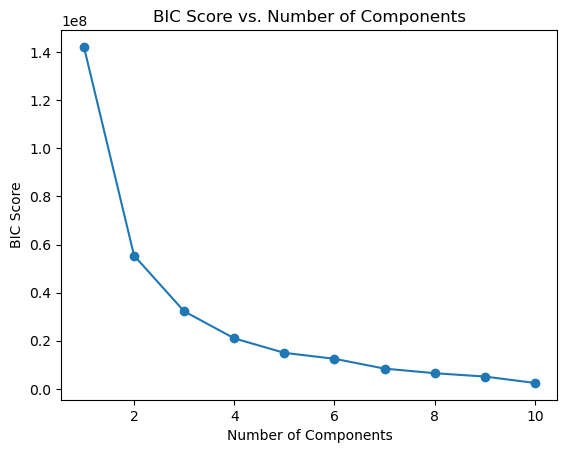

In [41]:
# Elbow Method

# Range of components to try
n_components_range = range(1, 11)

# Fit GMMs with different components and calculate the BIC (Bayesian Information Criterion)
bic_scores = []
for n_components in n_components_range:
    print(n_components)
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(data_for_anomaly_detection_standardized)
    bic_scores.append(gmm.bic(data_for_anomaly_detection_standardized))

# Plot the BIC scores
plt.plot(n_components_range, bic_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('BIC Score')
plt.title('BIC Score vs. Number of Components')
plt.show()

In [42]:
# # Elbow Method

# # Range of components to try
# n_components_range = range(8, 20)

# # Fit GMMs with different components and calculate the BIC (Bayesian Information Criterion)
# bic_scores = []
# for n_components in n_components_range:
#     gmm = GaussianMixture(n_components=n_components, random_state=42)
#     gmm.fit(data_for_anomaly_detection_standardized)
#     bic_scores.append(gmm.bic(data_for_anomaly_detection_standardized))

# # Plot the BIC scores
# plt.plot(n_components_range, bic_scores, marker='o')
# plt.xlabel('Number of Components')
# plt.ylabel('BIC Score')
# plt.title('BIC Score vs. Number of Components')
# plt.show()

15
25
35
45


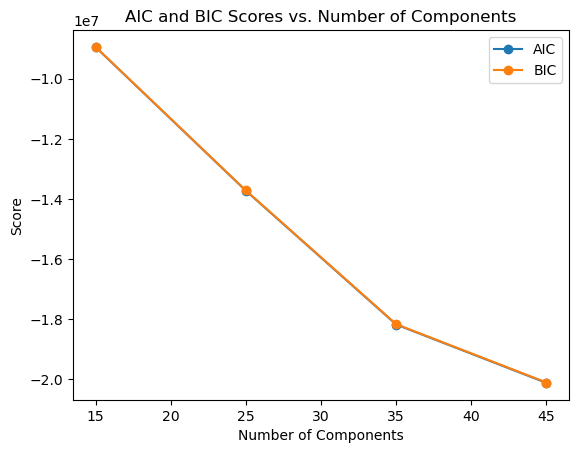

In [44]:
# AIC and BIC
from sklearn.mixture import GaussianMixture

n_components_range = range(15, 55, 10)

# Calculate AIC and BIC scores
aic_scores = []
bic_scores = []
for n_components in n_components_range:
    print(n_components)
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(data_for_anomaly_detection_standardized)
    aic_scores.append(gmm.aic(data_for_anomaly_detection_standardized))
    bic_scores.append(gmm.bic(data_for_anomaly_detection_standardized))

# Plot AIC and BIC scores
plt.plot(n_components_range, aic_scores, marker='o', label='AIC')
plt.plot(n_components_range, bic_scores, marker='o', label='BIC')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.title('AIC and BIC Scores vs. Number of Components')
plt.legend()
plt.show()


The silhouette score is a measure of how well-separated clusters are in your data. It ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.

Here's how you can interpret the silhouette score:

Closer to +1: Indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. This suggests a good, compact cluster.

Close to 0: Indicates that the object is on or very close to the decision boundary between two neighboring clusters. It could be on the border of two clusters or in an area where a cluster is not well-defined.

Closer to -1: Indicates that those clusters might have been assigned incorrectly.

When using silhouette scores to determine the optimal number of components (clusters) in a Gaussian Mixture Model (GMM), you typically look for the maximum silhouette score. The number of components corresponding to the peak silhouette score is considered a good choice for the number of clusters.

In your code, you're iterating over different numbers of components and calculating silhouette scores for each. The number of components that gives the highest silhouette score is often chosen as the optimal number of clusters.

Here's how to decide the best number of components based on the silhouette score:

Look for the Peak: Examine the plot of silhouette scores against the number of components. The point where the silhouette score is highest is a good candidate for the optimal number of components.

Consider Stability: Ensure that the peak is stable and not a result of random fluctuations. You may want to run the analysis multiple times or use cross-validation to verify the stability of the silhouette score.

Domain Knowledge: Consider your domain knowledge and the context of your data. Sometimes, a specific number of clusters may align with meaningful patterns in the data.

Balance Complexity: While a higher number of components might increase the silhouette score, it could also lead to overfitting or capturing noise in the data. Strike a balance between simplicity and goodness of fit.

In summary, choose the number of components that maximizes the silhouette score while considering the stability and context of your data.

In [ ]:
# Sihouett Score

from sklearn.metrics import silhouette_score

# Range of components to try
n_components_range = range(2, 11)

# Calculate silhouette scores
silhouette_scores = []
for n_components in n_components_range:
    print(n_components)
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(data_for_anomaly_detection_standardized)
    labels = gmm.predict(data_for_anomaly_detection_standardized)
    silhouette_scores.append(silhouette_score(data_for_anomaly_detection_standardized, labels))

# Plot silhouette scores
plt.plot(n_components_range, silhouette_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Components')
plt.show()


2


KeyboardInterrupt: 

10
20
30
40
50
60
70


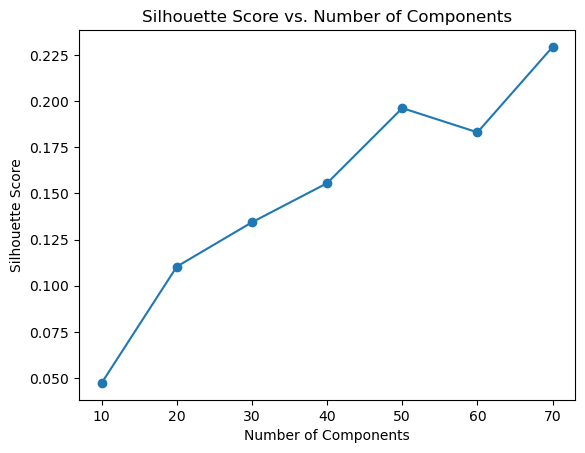

In [ ]:
# Sihouett Score

from sklearn.metrics import silhouette_score

# Range of components to try
n_components_range = range(10, 80, 10)

# Calculate silhouette scores
silhouette_scores = []
for n_components in n_components_range:
    print(n_components)
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(data_for_anomaly_detection_standardized)
    labels = gmm.predict(data_for_anomaly_detection_standardized)
    silhouette_scores.append(silhouette_score(data_for_anomaly_detection_standardized, labels))

# Plot silhouette scores
plt.plot(n_components_range, silhouette_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Components')
plt.show()


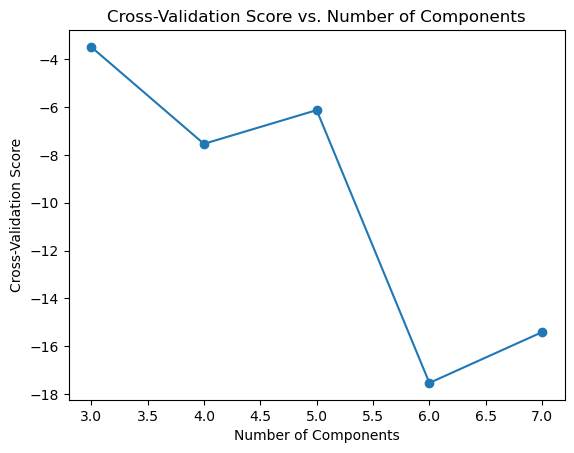

In [ ]:
# Cross-validation

# Evaluation with Cross-Validation: Cross-validation is 
# used to assess how well the model generalizes to new, unseen data. 
# A higher likelihood score in cross-validation suggests that the model 
# is better at capturing the normal patterns in the data, leading to 
# higher probabilities for typical observations.


from sklearn.model_selection import cross_val_score

n_components_range = range(3, 8)

# Cross-validation scores
cv_scores = []
for n_components in n_components_range:
    print(n_components)
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    scores = cross_val_score(gmm, data_for_anomaly_detection_standardized, cv=5)
    cv_scores.append(np.mean(scores))

# Plot cross-validation scores
plt.plot(n_components_range, cv_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cross-Validation Score')
plt.title('Cross-Validation Score vs. Number of Components')
plt.show()


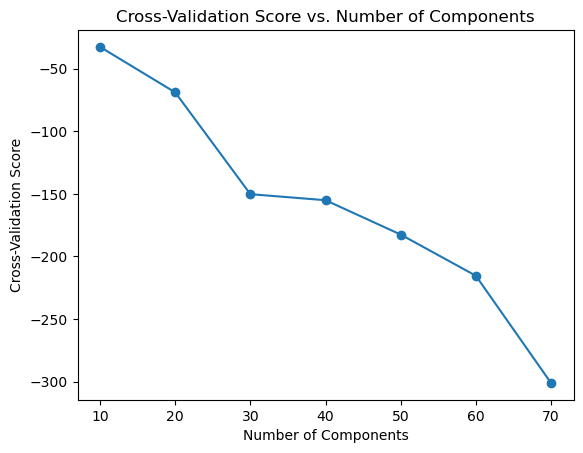

In [ ]:
# Cross-validation

# Evaluation with Cross-Validation: Cross-validation is 
# used to assess how well the model generalizes to new, unseen data. 
# A higher likelihood score in cross-validation suggests that the model 
# is better at capturing the normal patterns in the data, leading to 
# higher probabilities for typical observations.


from sklearn.model_selection import cross_val_score

n_components_range = range(10, 80, 10)

# Cross-validation scores
cv_scores = []
for n_components in n_components_range:
    print(n_components)
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    scores = cross_val_score(gmm, data_for_anomaly_detection_standardized, cv=5)
    cv_scores.append(np.mean(scores))

# Plot cross-validation scores
plt.plot(n_components_range, cv_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cross-Validation Score')
plt.title('Cross-Validation Score vs. Number of Components')
plt.show()


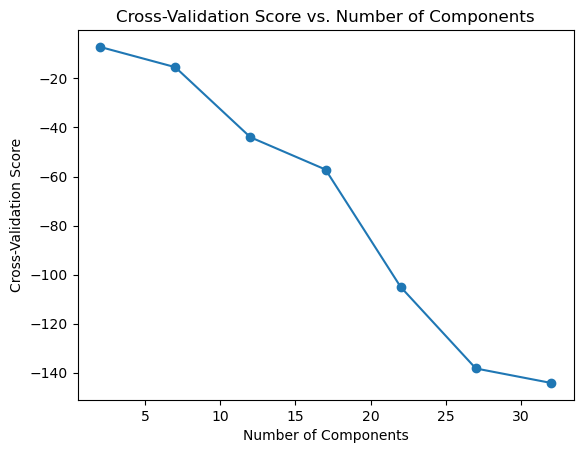

In [ ]:
# Cross-validation

# Evaluation with Cross-Validation: Cross-validation is 
# used to assess how well the model generalizes to new, unseen data. 
# A higher likelihood score in cross-validation suggests that the model 
# is better at capturing the normal patterns in the data, leading to 
# higher probabilities for typical observations.


from sklearn.model_selection import cross_val_score

n_components_range = range(2, 35, 5)

# Cross-validation scores
cv_scores = []
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    scores = cross_val_score(gmm, data_for_anomaly_detection_standardized, cv=5)
    cv_scores.append(np.mean(scores))

# Plot cross-validation scores
plt.plot(n_components_range, cv_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cross-Validation Score')
plt.title('Cross-Validation Score vs. Number of Components')
plt.show()


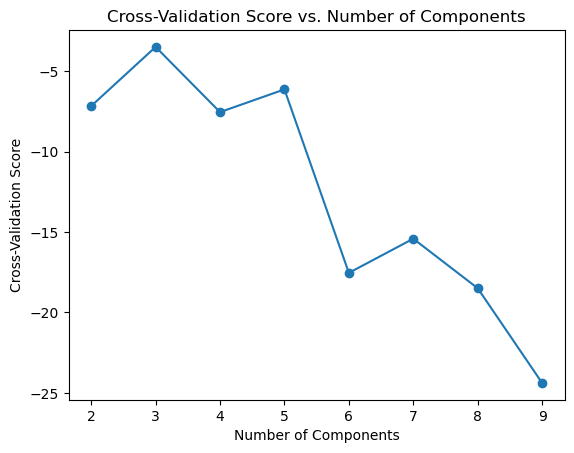

In [ ]:
# Cross-validation

# Evaluation with Cross-Validation: Cross-validation is 
# used to assess how well the model generalizes to new, unseen data. 
# A higher likelihood score in cross-validation suggests that the model 
# is better at capturing the normal patterns in the data, leading to 
# higher probabilities for typical observations.


from sklearn.model_selection import cross_val_score

n_components_range = range(2, 10)

# Cross-validation scores
cv_scores = []
for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    scores = cross_val_score(gmm, data_for_anomaly_detection_standardized, cv=5)
    cv_scores.append(np.mean(scores))

# Plot cross-validation scores
plt.plot(n_components_range, cv_scores, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cross-Validation Score')
plt.title('Cross-Validation Score vs. Number of Components')
plt.show()


By jointly considering the AIC/BIC and cross-validation scores, we should choose `n_components = 5`.

### Choosing `threshold`

Choosing the threshold for anomaly detection is a critical step, and there is no one-size-fits-all answer. The optimal threshold depends on the characteristics of the data, the distribution of likelihood scores, and the specific requirements for balancing false positives and false negatives. Here are some approaches you can consider:

1. Visual Inspection: Visualize the distribution of likelihood scores and identify a threshold that clearly separates normal data from potential anomalies. Plot a histogram or kernel density estimate of the likelihood scores and look for a point where anomalies appear distinct.
2. Quantile-Based Threshold: Choose a threshold based on a certain quantile of the likelihood scores. For example, set the threshold at the 95th percentile to capture the top 5% of data points as anomalies.
3. Empirical Rule: If the likelihood scores follow a normal distribution, you might consider using the empirical rule (e.g., three standard deviations from the mean) to set a threshold.
4. ROC Curve (only if we have the labeled data) or Other Evaluation Metrics (precision, F1-score, ect.).

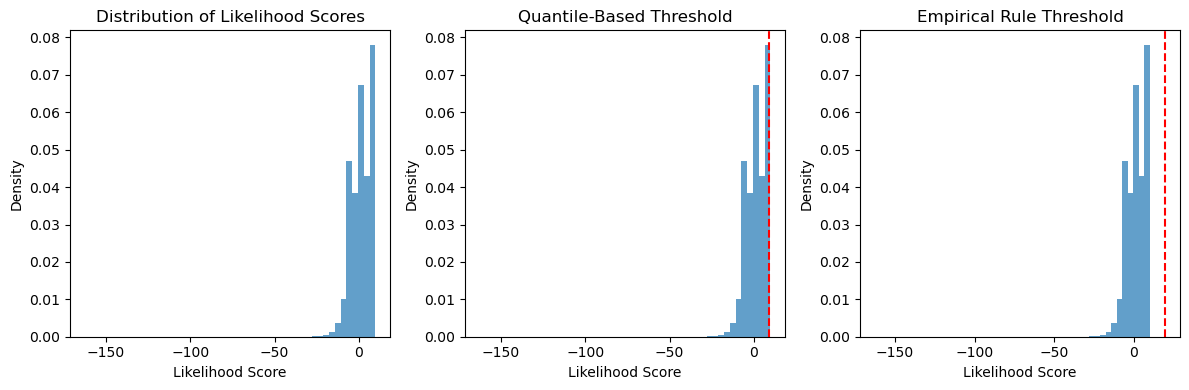

Quantile-Based Threshold: 8.74
Empirical Rule Threshold: 19.75


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Assuming you have a variable 'score' with the likelihood scores

# Visual Inspection
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(score, bins=50, density=True, alpha=0.7)
plt.xlabel('Likelihood Score')
plt.ylabel('Density')
plt.title('Distribution of Likelihood Scores')

# Quantile-Based Threshold (e.g., 95th percentile)
threshold_quantile = np.percentile(score, 95)
plt.subplot(1, 3, 2)
plt.hist(score, bins=50, density=True, alpha=0.7)
plt.axvline(x=threshold_quantile, color='red', linestyle='--', label='Threshold (95th percentile)')
plt.xlabel('Likelihood Score')
plt.ylabel('Density')
plt.title('Quantile-Based Threshold')

# Empirical Rule (e.g., three standard deviations from the mean)
mean_score = np.mean(score)
std_dev_score = np.std(score)
threshold_empirical = mean_score + 3 * std_dev_score
plt.subplot(1, 3, 3)
plt.hist(score, bins=50, density=True, alpha=0.7)
plt.axvline(x=threshold_empirical, color='red', linestyle='--', label='Threshold (3 std deviations)')
plt.xlabel('Likelihood Score')
plt.ylabel('Density')
plt.title('Empirical Rule Threshold')

plt.tight_layout()
plt.show()

# # ROC Curve and AUC (only if you have labeled data)
# # Assuming 'labels' is an array of true labels (0 for normal, 1 for anomaly)
# fpr, tpr, _ = roc_curve(labels, -score)  # Use -score for maximizing the area under the curve
# roc_auc = auc(fpr, tpr)

# # Precision-Recall Curve and AUC
# precision, recall, _ = precision_recall_curve(labels, -score)
# pr_auc = average_precision_score(labels, -score)

# plt.figure(figsize=(10, 4))

# plt.subplot(1, 2, 1)
# plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic Curve')
# plt.legend(loc='lower right')

# plt.subplot(1, 2, 2)
# plt.plot(recall, precision, color='darkorange', lw=2, label=f'PR Curve (AUC = {pr_auc:.2f})')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.legend(loc='upper right')

# plt.tight_layout()
# plt.show()

# Print or return the chosen thresholds
print(f"Quantile-Based Threshold: {threshold_quantile:.2f}")
print(f"Empirical Rule Threshold: {threshold_empirical:.2f}")


In [ ]:
# # Visualize the distribution of likelihood scores
# threshold = -1.5
# plt.hist(score, bins=50, density=True, alpha=0.5)
# plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label='Threshold')
# plt.xlabel('Likelihood Score')
# plt.ylabel('Density')
# plt.title('Distribution of Likelihood Scores')
# plt.legend()
# plt.show()


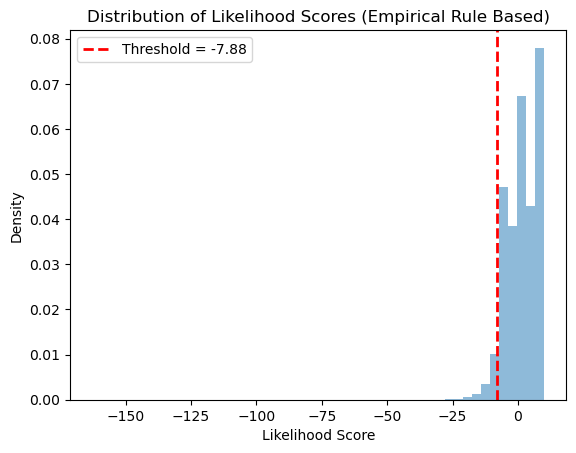

In [ ]:
# Choose the threshold at the 5th, 95th percentile
threshold = np.percentile(score, 5)
threshold

# Visualize the distribution of likelihood scores

plt.hist(score, bins=50, density=True, alpha=0.5)
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label='Threshold')
plt.xlabel('Likelihood Score')
plt.ylabel('Density')
plt.title('Distribution of Likelihood Scores (Empirical Rule Based)')
plt.legend(labels=[f'Threshold = {round(threshold, 2)}'])
plt.show()


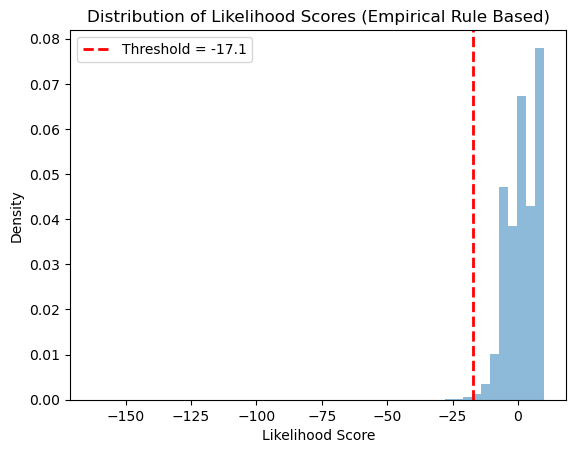

In [ ]:
# Choose the threshold based on the empirical rule

mean_likelihood = np.mean(score)
std_dev_likelihood = np.std(score)
threshold = mean_likelihood - 3 * std_dev_likelihood
threshold

# Visualize the distribution of likelihood scores

plt.hist(score, bins=50, density=True, alpha=0.5)
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label='Threshold')
plt.xlabel('Likelihood Score')
plt.ylabel('Density')
plt.title('Distribution of Likelihood Scores (Empirical Rule Based)')
plt.legend(labels=[f'Threshold = {round(threshold, 2)}'])
plt.show()
